In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, img_shape),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

# Hyperparameters
latent_dim = 100
img_shape = 28 * 28
batch_size = 64
epochs = 20
lr = 0.0002
b1 = 0.5
b2 = 0.999

# Prepare data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize models and optimizers
generator = Generator(latent_dim, img_shape).cuda()
discriminator = Discriminator(img_shape).cuda()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Loss function
adversarial_loss = nn.BCELoss()

# Record the start time for training
total_start_time = time.time()

# Training loop
for epoch in range(epochs):
    # Record the start time for the epoch
    epoch_start_time = time.time()

    # Variables to store cumulative losses
    total_d_loss = 0.0
    total_g_loss = 0.0

    for i, (imgs, _) in enumerate(tqdm(dataloader)):
        # Record the start time for the batch
        batch_start_time = time.time()

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).cuda()
        fake = torch.zeros(imgs.size(0), 1).cuda()

        # Configure input
        real_imgs = imgs.cuda()

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).cuda()
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Accumulate losses
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

        # Record the end time for the batch and calculate elapsed time
        batch_end_time = time.time()
        elapsed_time_batch = batch_end_time - batch_start_time

        # Print batch progress with elapsed time
        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] [Time: {elapsed_time_batch:.2f} seconds]")

    # Calculate average losses for the epoch
    avg_d_loss = total_d_loss / len(dataloader)
    avg_g_loss = total_g_loss / len(dataloader)

    # Print average losses at the end of the epoch
    print(f"[Epoch {epoch}/{epochs}] [Avg D loss: {avg_d_loss:.4f}] [Avg G loss: {avg_g_loss:.4f}]")

    # Record the end time for the epoch and calculate elapsed time
    epoch_end_time = time.time()
    elapsed_time_epoch = epoch_end_time - epoch_start_time

    # Save generated images at the end of each epoch
    if epoch % 5 == 0:
        with torch.no_grad():
            z = torch.randn(25, latent_dim).cuda()
            gen_imgs = generator(z)
            gen_imgs = gen_imgs.cpu().numpy().reshape((-1, 28, 28))
            plt.figure(figsize=(5, 5))
            for i in range(gen_imgs.shape[0]):
                plt.subplot(5, 5, i + 1)
                plt.imshow(gen_imgs[i], cmap='gray')
                plt.axis('off')
            plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
            plt.close()

# Record the end time for training
total_end_time = time.time()
total_elapsed_time = total_end_time - total_start_time

# Print total training time
print(f"Total training time: {total_elapsed_time:.2f} seconds")


Output hidden; open in https://colab.research.google.com to view.

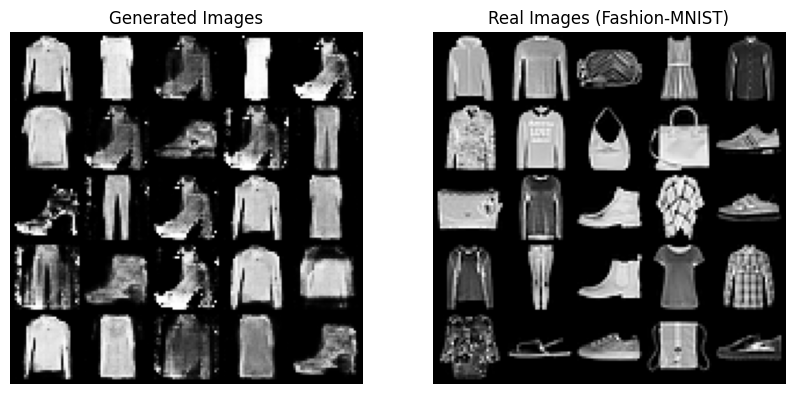

In [3]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import datasets, transforms

# Set the generator to evaluation mode
generator.eval()

# Generate 25 images
with torch.no_grad():
    z = torch.randn(25, latent_dim).cuda()
    generated_images = generator(z)

# Load 25 real images from the Fashion-MNIST dataset
real_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=25, shuffle=True)

real_images, _ = next(iter(real_dataloader))
real_images = real_images.cuda()

# Create a grid of generated images
grid_generated = vutils.make_grid(generated_images, nrow=5, normalize=True)

# Create a grid of real images
grid_real = vutils.make_grid(real_images, nrow=5, normalize=True)

# Display the comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(grid_generated.permute(1, 2, 0).cpu().numpy())
axes[0].set_title('Generated Images')
axes[0].axis('off')

axes[1].imshow(grid_real.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[1].set_title('Real Images (Fashion-MNIST)')
axes[1].axis('off')

plt.show()


In [4]:
import torch
import time

# Set the generator to evaluation mode
generator.eval()

# Record the start time
start_time = time.time()

# Generate 25 images
with torch.no_grad():
    z = torch.randn(25, latent_dim).cuda()
    generated_images = generator(z)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the time taken to generate 25 images
print(f"Time taken to generate 25 images: {elapsed_time:.4f} seconds")


Time taken to generate 25 images: 0.0022 seconds
